In [ ]:
!pip install tensorflow pycaret pandas scikit-learn nfl_data_py matplotlib


In [ ]:
import nfl_data_py as nfl
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import accuracy_score, classification_report
from pycaret.classification import setup, compare_models, plot_model, predict_model
import matplotlib.pyplot as plt
import json



In [ ]:
# Load play-by-play data for seasons 2010–2024
seasons = list(range(2010, 2025))
pbp_data = nfl.import_pbp_data(seasons)

# Filter for fourth-down plays and relevant features
columns_to_keep = [
    'season', 'posteam', 'defteam', 'yardline_100', 'half_seconds_remaining',
    'game_half', 'qtr', 'ydstogo', 'score_differential', 'posteam_timeouts_remaining', 'defteam_timeouts_remaining', 'no_huddle',
    'shotgun', 'total_home_score', 'total_away_score'
]
data = pbp_data[pbp_data['down'] == 4][columns_to_keep].dropna()

# Create target variable: 1 if the team went for it, 0 otherwise
data['went_for_it'] = pbp_data['play_type'].apply(lambda x: 1 if x in ['run', 'pass'] else 0)

# One-hot encode categorical variables
categorical_columns = ['posteam', 'defteam', 'game_half']
data = pd.get_dummies(data, columns=categorical_columns, drop_first=True)

# Save full dataset
folder_path = "/content/drive/MyDrive/Data_5500/final_project/data"
if not os.path.exists(folder_path):
    os.makedirs(folder_path)
data.to_csv(os.path.join(folder_path, "full_data.csv"), index=False)


2010 done.
2011 done.
2012 done.
2013 done.
2014 done.
2015 done.
2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
2023 done.
2024 done.
Downcasting floats.


In [ ]:
# Split into training (2010–2023) and testing (2024) data
train_data = data[data['season'] <= 2023].drop(columns=['season'])
test_data = data[data['season'] == 2024].drop(columns=['season'])

# Save training and testing datasets
train_data.to_csv(os.path.join(folder_path, "train_data.csv"), index=False)
test_data.to_csv(os.path.join(folder_path, "test_data.csv"), index=False)

# Separate features (X) and target (y)
X_train = train_data.drop(columns=['went_for_it'])
y_train = train_data['went_for_it']
X_test = test_data.drop(columns=['went_for_it'])
y_test = test_data['went_for_it']



In [ ]:
# Define and compile the Keras model
model = Sequential([
    Dense(64, input_dim=X_train.shape[1], activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

# Predict on the test set
keras_preds = (model.predict(X_test) > 0.5).astype(int).flatten()

# Evaluate the Keras model
keras_accuracy = accuracy_score(y_test, keras_preds)
print(f"Keras Neural Network Accuracy: {keras_accuracy:.4f}")
print(classification_report(y_test, keras_preds))


Epoch 1/50
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8594 - loss: 0.5582
Epoch 2/50
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9168 - loss: 0.2848
Epoch 3/50
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9227 - loss: 0.2651
Epoch 4/50
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9265 - loss: 0.2277
Epoch 5/50
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9311 - loss: 0.2110
Epoch 6/50
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9309 - loss: 0.2106
Epoch 7/50
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9360 - loss: 0.1844
Epoch 8/50
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9352 - loss: 0.1801
Epoch 9/50
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9383 - loss: 0.1762
Epoch 10/50
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9374 - loss: 0.1778
Epoch 11/50
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9399 - loss: 0.1657
Epoch 12/50
1825/1825 ━━━━━━━━

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.9556,0.9702,0.8354,0.8465,0.8408,0.8150,0.8151,2.8540
xgboost,Extreme Gradient Boosting,0.9537,0.9694,0.8253,0.8422,0.8335,0.8067,0.8068,0.9540
gbc,Gradient Boosting Classifier,0.9535,0.9680,0.8333,0.8353,0.8342,0.8071,0.8072,7.8570
rf,Random Forest Classifier,0.9528,0.9658,0.7934,0.8600,0.8252,0.7980,0.7989,6.6330
ada,Ada Boost Classifier,0.9422,0.9636,0.7070,0.8568,0.7745,0.7417,0.7464,2.2850
et,Extra Trees Classifier,0.9417,0.9597,0.6699,0.8872,0.7631,0.7306,0.7401,9.1830
ridge,Ridge Classifier,0.9396,0.9462,0.6429,0.8984,0.7492,0.7160,0.7291,0.1170
lda,Linear Discriminant Analysis,0.9396,0.9462,0.6429,0.8984,0.7492,0.7160,0.7291,0.2830
lr,Logistic Regression,0.9373,0.9507,0.6253,0.8968,0.7366,0.7023,0.7172,9.4450
qda,Quadratic Discriminant Analysis,0.9291,0.8929,0.6819,0.7854,0.7297,0.6891,0.6916,0.4870


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

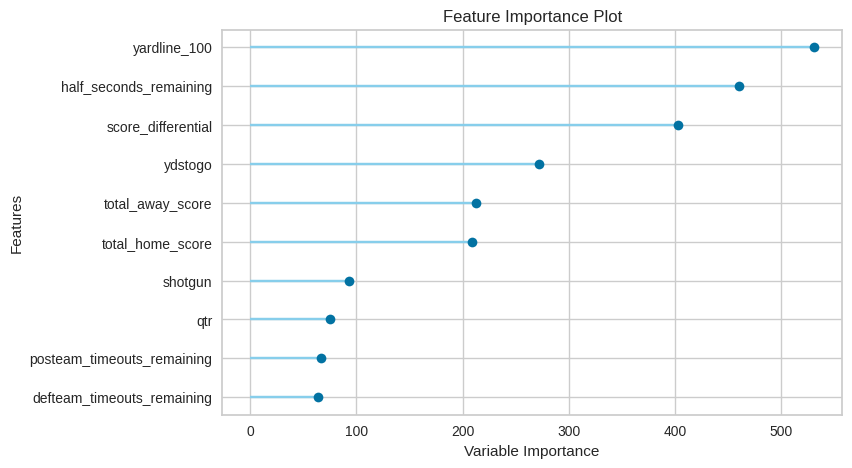

In [ ]:
# Combine training data for PyCaret
train_combined = pd.concat([X_train, y_train], axis=1)

# Set up PyCaret environment
exp = setup(train_combined, target='went_for_it', session_id=123, verbose=False, use_gpu=False)

# Compare models
best_model = compare_models()

# Plot feature importance for the best model
plot_model(best_model, plot='feature')




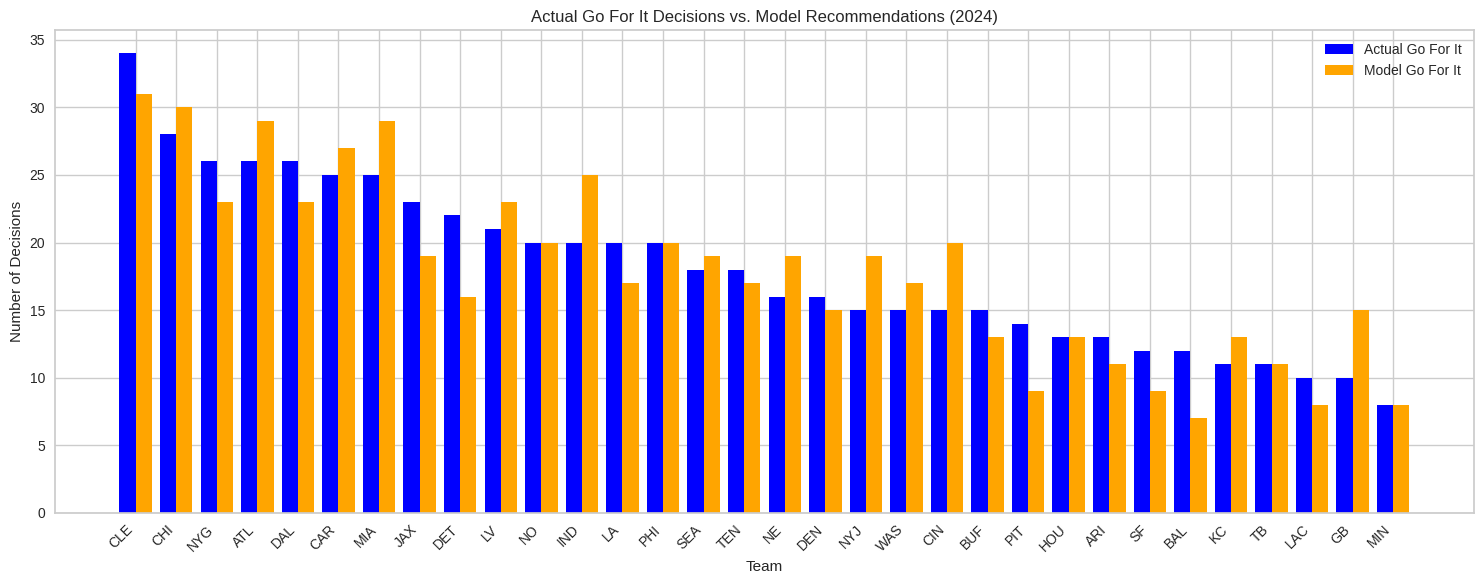

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate total number of "go for it" decisions made by each team
team_actual_go_for_it = test_data.groupby('original_posteam').agg(
    actual_go_for_it=('actual_decision', 'sum')  # Total times the team actually went for it
).reset_index()

# Calculate total number of times the model recommended "go for it" for each team
team_model_go_for_it = test_data.groupby('original_posteam').agg(
    model_go_for_it=('model_prediction', 'sum')  # Total times the model recommended going for it
).reset_index()

# Merge the two DataFrames
team_comparison = team_actual_go_for_it.merge(team_model_go_for_it, on='original_posteam')

# Sort for better visualization
team_comparison = team_comparison.sort_values(by='actual_go_for_it', ascending=False)

# Plot grouped bar chart
x = np.arange(len(team_comparison['original_posteam']))  # Team indices for x-axis
width = 0.4  # Bar width

plt.figure(figsize=(15, 6))

# Actual "Go For It" decisions (blue bars)
plt.bar(x - width/2, team_comparison['actual_go_for_it'], width, color='blue', label='Actual Go For It')

# Model "Go For It" recommendations (orange bars)
plt.bar(x + width/2, team_comparison['model_go_for_it'], width, color='orange', label='Model Go For It')

# Customize the plot
plt.xticks(x, team_comparison['original_posteam'], rotation=45, ha='right')  # Add team names to x-axis
plt.xlabel('Team')
plt.ylabel('Number of Decisions')
plt.title('Actual Go For It Decisions vs. Model Recommendations (2024)')
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# Define a threshold for categorization (adjust as needed)
threshold = 3

# Categorize teams based on their behavior
def categorize_team(row):
    if row['actual_go_for_it'] > row['model_go_for_it'] + threshold:
        return 'Aggressive'
    elif abs(row['actual_go_for_it'] - row['model_go_for_it']) <= threshold:
        return 'Balanced'
    elif row['actual_go_for_it'] < row['model_go_for_it'] - threshold:
        return 'Conservative'
    else:
        return 'Uncategorized'

# Apply the categorization function to the DataFrame
team_comparison['category'] = team_comparison.apply(categorize_team, axis=1)

# Display categorized teams
print(team_comparison[['original_posteam', 'actual_go_for_it', 'model_go_for_it', 'category']])


   original_posteam  actual_go_for_it  model_go_for_it      category
7               CLE                34               31      Balanced
5               CHI                28               30      Balanced
23              NYG                26               23      Balanced
1               ATL                26               29      Balanced
8               DAL                26               23      Balanced
4               CAR                25               27      Balanced
19              MIA                25               29  Conservative
14              JAX                23               19    Aggressive
10              DET                22               16    Aggressive
18               LV                21               23      Balanced
22               NO                20               20      Balanced
13              IND                20               25  Conservative
16               LA                20               17      Balanced
25              PHI               

In [ ]:
# Save model accuracy and team compliance results
results = {
    "keras_accuracy": keras_accuracy,  # Accuracy of the Keras neural network
    "pycaret_best_model": str(best_model),  # Description of the best model from PyCaret
    "team_compliance": team_comparison.to_dict(orient='records')  # Team compliance data
}

# Save results to JSON
results_json_path = os.path.join(folder_path, "results.json")
with open(results_json_path, "w") as f:
    json.dump(results, f, indent=4)

print(f"Results saved to {results_json_path}")

# Save team compliance data to CSV for easier analysis
compliance_csv_path = os.path.join(folder_path, "team_compliance.csv")
team_comparison.to_csv(compliance_csv_path, index=False)

print(f"Team compliance data saved to {compliance_csv_path}")



Results saved to /content/drive/MyDrive/Data_5500/final_project/data/results.json
Team compliance data saved to /content/drive/MyDrive/Data_5500/final_project/data/team_compliance.csv
